In [ ]:
import torch
from torch import nn
from torch.optim import lr_scheduler
import pandas as pd
import torch.nn.functional as F
import torchvision.transforms as transforms  
import torchvision
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import pandas as pd
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.optim as optim
import time
import torch.backends.cudnn as cudnn
import copy
cudnn.benchmark = True
plt.ion()

In [ ]:
data_transforms = {
    'train': torchvision.transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])
                                      ])
,
    'val':torchvision.transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])}


data_dir = '/content/drive/MyDrive/eg-currency'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class_names

['0.5 coin ',
 '0.5 pound ',
 '1 pound',
 '1 pound coin ',
 '10 pound',
 '10 pound new',
 '100 pounds',
 '20 pounds',
 '200 pounds',
 '5 pounds',
 '50 pounds']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    l2_lambda = 0.001
                    l2_norm = sum(p.pow(2.0).sum()
                                  for p in model.parameters())
 
                    loss = loss + l2_lambda * l2_norm

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model_conv = torchvision.models.convnext_small(pretrained=True)
model_conv.classifier[2] = nn.Linear(model_conv.classifier[2].in_features, 11)
model_conv = model_conv.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer_conv =torch.optim.SGD(model_conv.parameters(), lr=0.001)
exp_lr_scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer_conv, milestones=[4,6], gamma=0.06)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 1.4562 Acc: 0.5777
val Loss: 1.4208 Acc: 0.5126

Epoch 1/7
----------
train Loss: 0.5866 Acc: 0.8849
val Loss: 0.9802 Acc: 0.6390

Epoch 2/7
----------
train Loss: 0.2834 Acc: 0.9560
val Loss: 0.7139 Acc: 0.7726

Epoch 3/7
----------
train Loss: 0.1418 Acc: 0.9886
val Loss: 0.5817 Acc: 0.8339

Epoch 4/7
----------
train Loss: 0.0816 Acc: 0.9952
val Loss: 0.5360 Acc: 0.8700

Epoch 5/7
----------
train Loss: 0.0796 Acc: 0.9964
val Loss: 0.5335 Acc: 0.8592

Epoch 6/7
----------
train Loss: 0.0746 Acc: 0.9994
val Loss: 0.5313 Acc: 0.8556

Epoch 7/7
----------
train Loss: 0.0761 Acc: 0.9952
val Loss: 0.5295 Acc: 0.8592

Training complete in 34m 4s
Best val Acc: 0.870036


In [ ]:
def prediction(im):
    img_tens = data_transforms['val'](im)
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model_conv(uinput)
    out = out.data.cpu().numpy().argmax()    
    return out

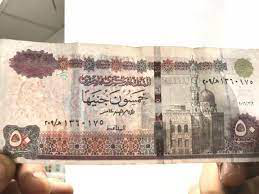

In [ ]:
img = Image.open('/content/Untitled Folder/images.jpg')
img

In [ ]:
out = prediction(img)
out

10